<a href="https://colab.research.google.com/github/Adeelzafar/30-Days-of-ML-Kaggle/blob/main/(final)_Unit_5_Detecting_Fake_News.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import sys
import os
import plotly.express as px
import seaborn as sns
import io
import requests

In [ ]:
from IPython.display import Image
Image(url="https://web.lums.edu.pk/~ihsan/workshop_data/unit5/dont-use-sanitizer.png", width=500, height=400)

Fake news---false information created in order to deceive others---is an important issue because it can harm people. For example, the social media post above confidently stated that hand sanitizer doesn't work on coronaviruses. Though factually incorrect, it spread through social media anyway: it was shared nearly 82,000 times, liked by nearly 241,000 times and was likely seen by millions of people.

**Can we create models to automatically detect fake news?**
In this case study, we'll use logistic regression 
to predict whether news articles are real or fake.
As usual, we'll go through the steps of the data science lifecycle.
We'll start by refining our research question and obtaining a dataset of news
articles and labels.
Then, we'll wrangle and transform the data.
Next, we'll explore the data to understand its content and
devise features that we can use for modeling.
Finally, we'll fit logistic regression models and evaluate their performance.

We've included this case study because it lets us reiterate several important
ideas in data science.
First, natural language data appear often, and even basic techniques can enable
interesting analyses.
Second, model selection is an important part of data analysis, and this case
study lets us apply what we've learned about cross-validation and the bias-variance tradeoff.
Finally, even models that perform well on the test set might have inherent
limitations when we try to use them in practice, as we'll soon see.

Let's start by refining our research question and understanding the scope of
our data.

Our initial research question is:
can we create models to automatically detect fake news?

To address this question, we'll use the [FakeNewsNet dataset](https://arxiv.org/abs/1809.01286). This dataset contains content from news and
social media websites, as well as metadata like user engagement metrics.
For simplicity, we'll only look at the dataset's political news articles.
The dataset only includes articles that
were fact-checked by [PolitiFact][politifact], a
non-partisan organization with a good reputation.
Each article in the FakeNewsNet dataset has a "real" or "fake" label based
on the Politifact's evaluation, which we'll use as the ground truth for whether
an article is true or false.

[politifact]: https://www.politifact.com/

Note that Politifact uses a non-random sampling method to select articles to fact-check. According to their website, their journalists select the "most newsworthy and significant" claims each day. Since Politifact started in 2007 and the research paper was published in 2020,
most of the articles in the dataset were published between 2007 and 2020.

With this in mind, the main sources of bias for this data include:

- **Coverage bias**: The news outlets are limited to those Politifact monitored, which may miss arcane or short-lived sites. Also since we have only articles published between 2007 and 2020, there is likely to be drift in the content. After all, the notion of fake news has evolved rapidly in the past 15 years.

- **Selection bias**: The data are limited to articles Politifact decided were interesting enough to fact-check, which means that articles might skew towards ones that are both widely shared and controversial.

- **Measurement bias**: The labels fake/real are determined by one organization (Politifact), and reflects the biases, unintentional or otherwise, that the organization has in its fact-checking methodology.

# Obtaining and Wrangling the Data

Let's get the data into Python.
The dataset has [a GitHub page][fnn-code] with the code that downloads the data.
Running the script to download the Politifact data takes about an hour.
After running the script, we placed the data files into a folder.
The articles that Politifact labeled as fake and real
are in `data/politifact/fake` and `data/politifact/real`.
Let's take a look at one of the articles labeled real.

[fnn-code]: https://github.com/KaiDMML/FakeNewsNet/tree/654361e1c8d5baa751baf1dac5032df621652280

In [ ]:
url="https://web.lums.edu.pk/~ihsan/workshop_data/unit5/fake_news.csv"
s=requests.get(url).content
df = pd.read_csv(url, parse_dates=['timestamp'])
df.count()

timestamp    404
baseurl      779
content      779
label        779
dtype: int64

# Exploring the Data

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df[['timestamp', 'baseurl', 'content']], df['label'],
    test_size=0.25, random_state=42,
)

In [ ]:
df.sample(10)

,timestamp,baseurl,content,label
62,NaT,theseattletribune.com,"Historical blog about Seattle, as well as the ...",fake
363,NaT,msnbc.msn.com,"Outlook, Office, Skype, Bing, Breaking News, a...",real
415,NaT,cq.com,CNN Holds Evening Republican Presidential Cand...,real
599,NaT,senate.gov,U.S. Senate: U.S. Senate Roll Call Votes 103rd...,real
228,2017-11-10 15:06:39,100percentfedup.com,JUST IN: WaPo Reporter Who Broke News On Judge...,fake
49,2017-05-02 07:00:00,americanflavor.news,JUST IN: Barack Obama ARRESTED in a Japanese D...,fake
63,2017-09-10 18:04:55,freedumjunkshun.com,Breaking: Mar-A-Lago Destroyed By Irma-Jared K...,fake
234,2018-03-28 23:30:27,newsdonaldtrumps.com,Robert Redford Says: Michelle And Barack Obama...,fake
588,NaT,bls.gov,CES (National) : U.S. Bureau of Labor Statisti...,real
622,NaT,www6.lexisnexis.com,LexisNexis(R) Publisher COPYRIGHT © 2005 Lexis...,real


In [ ]:
# X_train is our training set
X_train.head(5)

,timestamp,baseurl,content
164,2019-01-04 19:25:46,worldnewsdailyreport.com,Chinese lunar rover finds no evidence of Ameri...
28,2016-01-12 21:02:28,occupydemocrats.com,Virginia Republican Wants Schools To Check Chi...
708,2017-05-28 07:00:00,foxnews.com,"Sec. John Kelly on Manchester investigation, k..."
193,2018-04-18 07:00:00,cnn.com,Last in Queen Elizabeth II’s line of corgis di...
218,NaT,cpsc.gov,Target Recalls Water Absorbing Toys Due to Ser...


We can see that our training set has about 60 more articles labeled as `real` compared to `fake`:

In [ ]:
y_train.value_counts()

real    320
fake    264
Name: label, dtype: int64

Our training set has 584 articles. There are only 306 non-null timestamps, as the code below shows:

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 584 entries, 164 to 102
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  306 non-null    datetime64[ns]
 1   baseurl    584 non-null    object        
 2   content    584 non-null    object        
dtypes: datetime64[ns](1), object(2)
memory usage: 18.2+ KB


Next, we'll take a closer look at the `baseurl`, which represents the website that published the original article.

## Exploring the Publishers


To understand the `baseurl` column, we can start by counting the number of articles that each website published.

In [ ]:
X_train['baseurl'].value_counts()

whitehouse.gov               21
abcnews.go.com               20
nytimes.com                  17
politifact.com               16
yournewswire.com             15
                             ..
truthexam.com                 1
apnews.com                    1
occupydemocrats.com           1
legis.state.ak.us             1
dailynewsforamericans.com     1
Name: baseurl, Length: 337, dtype: int64

Our training set has 584 rows, and the code above shows that there are 337 unique publishing websites. This implies that many websites published a few articles. A histogram of the number of articles published by each website confirms this:

In [ ]:
px.histogram(X_train['baseurl'].value_counts(), width=650, height=450)

This histogram shows that the vast majority (261 out of 337) of websites published only one article in the training set, and only a few websites published more than 5 articles total.

Nonetheless, we can still take a look at the websites that published the most fake and real articles. First, we'll start with the websites that published the most fake articles:

In [ ]:
top_fake_publishers = (X_train
 .assign(label=y_train)
 .query('label == "fake"')
 ['baseurl']
 .value_counts()
 .iloc[:10]
 .sort_values()
)
px.bar(top_fake_publishers, orientation='h', width=550, height=450)

Next, we'll take a look at the websites that published real articles:

In [ ]:
top_real_publishers = (X_train
 .assign(label=y_train)
 .query('label == "real"')
 ['baseurl']
 .value_counts()
 .iloc[:10]
 .sort_values()
)
px.bar(top_real_publishers, orientation='h', width=550, height=450)

Based on these bar charts, we might expect that an article from `yournewswire.com` is more likely to be labeled `fake`, while an article from `whitehouse.gov` is more likely to be labeled `real`. That said, we wouldn't expect that using the publishing website to predict article truthfulness would work very well -- there are simply too few articles published by most websites in the dataset.

Next, let's explore the `timestamp` column, which records the publish time of each news article.

## Exploring the Publish Times

Plotting the timestamps on a histogram shows that most articles were published after 2000, although there seem to be at least one article published before 1940:

In [ ]:
px.histogram(X_train['timestamp'], width=750, height=350)

Taking a closer look at the new articles published before 2000 in the dataset would show that the timestamps don't match the actual publish date of the article. These data issues are most likely related to the web scraper getting inaccurate information from the web pages, so we can zoom into the region of the histogram after 2000.

In [ ]:
px.histogram(X_train.loc[X_train['timestamp'] > '2000', 'timestamp'],
             width=750, height=350)

As we expect, most articles in the dataset were published between 2007 (the year Politifact was founded) and 2020 (the year the FakeNewsNet paper was published). We also find out that the timestamps are concentrated on the years 2016-2018, the years following the controversial 2016 US Presidential Election.

This brief exploratory analysis helps us understand when our news articles were published and that the dataset captures a broad range of publishing websites. Next, we'll use the content of the news articles themselves to make predictions about whether articles are fake or real.

# Modeling

In [ ]:
url="https://web.lums.edu.pk/~ihsan/workshop_data/unit5/fake_news.csv"
s=requests.get(url).content

#date_parser = lambda x: pd.to_datetime(x, format='%d/%m/%Y')
df = pd.read_csv(url, parse_dates=['timestamp'])

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df[['timestamp', 'baseurl', 'content']], df['label'],
    test_size=0.25, random_state=42,
)

Now that we've obtained, cleaned, and explored our data, let's fit models to predict whether articles are real or fake. Since we're classifying articles, we'll use logistic regression. We'll fit three different models that increase in complexity. First, we'll fit a model that just uses a single hand-picked word as a binary feature. Then, we'll fit a model that uses multiple hand-picked words. Finally, we'll fit a model that uses all the words in the training set, vectorized using the tf-idf transform. Let's start with the simple single-word model.

## Single-Word Model

From our EDA, we know that many articles were published soon after the 2016 US Presidential Election. In that election, the two candidates were named Donald Trump and Hillary Clinton. Readers who followed the election that year may already know that the election was quite divisive, which suggests that the word `trump` could be predictive of whether articles in our dataset are real or fake. To test this, we'll fit a logistic regression classifier using a single binary feature: `1` if the word `trump` appears in the article and `0` if not. Since we'll want to add more word features like this one later in this analysis, we'll write the code so that it can extend to multiple words.

We'll start by defining functions to lowercase the article content and create binary word features.

In [ ]:
def lowercase(df):
    return df.assign(content=df['content'].str.lower())

In [ ]:
# For our first classifier, we'll only use the word `trump`.
word_features = [
    'trump',
]

In [ ]:
# This function creates one new binary feature for each word in word_features,
# marking the presence of a word in an article.
def make_word_features(df, words=word_features):
    features = { word: df['content'].str.contains(word) for word in words }
    return pd.DataFrame(features)

### Exploring Words in Articles

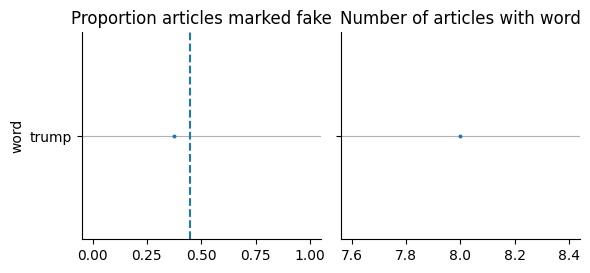

In [ ]:
fake_props = (make_word_features(X_train, word_features)
 .assign(label=(y_train == 'fake'))
 .melt(id_vars=['label'], var_name='word', value_name='appeared')
 .query('appeared == True')
 .groupby('word')
 ['label']
 .agg(['mean', 'count'])
 .rename(columns={'mean': 'prop_fake'})
 .sort_values('prop_fake', ascending=False)
 .reset_index()
 .melt(id_vars='word')
)

g = sns.catplot(data=fake_props, x='value', y='word', col='variable',
                s=8, jitter=False, sharex=False, height=3)

[[prop_ax, _]] = g.axes
prop_ax.axvline(0.45, linestyle='--')
prop_ax.set(xlim=(-0.05, 1.05))

titles = ['Proportion articles marked fake', 'Number of articles with word']

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)
    ax.set(xlabel=None)

    # Make the grid horizontal instead of vertical
    ax.yaxis.grid(True);

In [ ]:
fake_props

,word,variable,value
0,trump,prop_fake,0.375
1,trump,count,8.000


We can chain these functions into a `scikit-learn` pipeline, which provides a convenient way to transform and fit data all at once.

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegressionCV

In [ ]:
from sklearn.preprocessing import FunctionTransformer

model1 = make_pipeline(
    FunctionTransformer(lowercase),
    FunctionTransformer(make_word_features, kw_args={'words': word_features}),
    LogisticRegressionCV(Cs=10,
                         solver='saga',
                         n_jobs=4,
                         max_iter=10000)
)

The pipeline above will lowercase the article content, create word features, and fit a logistic regression on the data. Using `LogisticRegressionCV` will by default use 5-fold cross-validation to select the best regularization parameter for the data.

Now, we can use the pipeline to fit the training data:

In [ ]:
%%time

model1.fit(X_train, y_train)
print(f'{model1.score(X_train, y_train):.1%} accuracy on training set.')

68.7% accuracy on training set.
CPU times: user 181 ms, sys: 8.59 ms, total: 190 ms
Wall time: 176 ms


We can plot a confusion matrix of the classifier on the training set to see what kinds of mistakes it made:

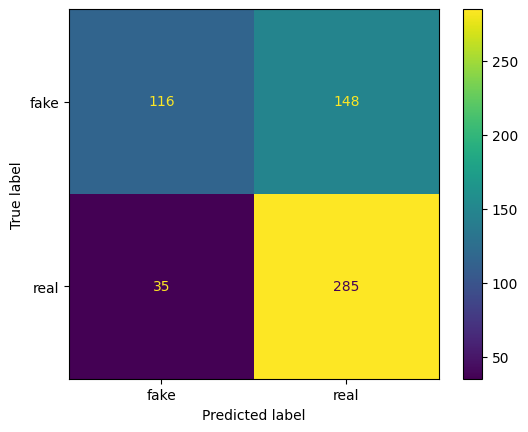

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

#ConfusionMatrixDisplay(model1, X_train, y_train, cmap=plt.cm.Blues)

predictions = model1.predict(X_train)
cm = confusion_matrix(y_train, predictions, labels=model1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model1.classes_)
disp.plot()
plt.show()

Overall, the single-word classifier only classifies 68.7% of articles correctly. It often misclassifies `fake` articles as `real`.

Since this model is simple, we can take a look at the parameters to understand
how it behaves completely.

In [ ]:
log_reg = model1.named_steps['logisticregressioncv']
coefs = (pd.DataFrame({'word': word_features, 'coef': log_reg.coef_[0]})
         .set_index('word')
         .sort_values('coef')
        )
coefs

,coef
word,
trump,-0.973348


In [ ]:
intercept = log_reg.intercept_[0]
print(f'Intercept: {intercept:.2f}')

Intercept: 0.45


Since the model has an intercept of 0.45 and the model weight for the `trump` feature is `-0.97`, the model will always predict that articles that contain the word `trump` are `fake` and articles that don't contain `trump` are `real`. We encourage readers to verify this for themselves using the definition of the logistic regression model.

Let's make our model a bit more sophisticated by introducing additional word features.

## Multiple Word Model


We can reuse much of the same code to create a model that uses multiple binary word features. To create our features, we'll use some domain knowledge about controversial topics during the 2016-2018 period:

In [ ]:
word_features = [
    # names of presidential candidates
    'trump', 'donald', 'hillary', 'clinton',
    
    # other possibly useful words
    'military', 'state', 'vote', 'congress', 'fbi', 'shutdown',
    'investig', 'antifa', 'joke', 'princ', 'homeless', 'cnn',
]

There are 16 features in this model. Let's fit a model using these features.

In [ ]:
from sklearn.preprocessing import FunctionTransformer

model2 = make_pipeline(
    FunctionTransformer(lowercase),
    FunctionTransformer(make_word_features, kw_args={'words': word_features}),
    LogisticRegressionCV(Cs=10,
                         solver='saga',
                         n_jobs=4,
                         max_iter=10000)
)

In [ ]:
%%time

model2.fit(X_train, y_train)
print(f'{model2.score(X_train, y_train):.1%} accuracy on training set.')

74.0% accuracy on training set.
CPU times: user 3.12 s, sys: 11.5 ms, total: 3.13 s
Wall time: 1.93 s


This model performed significantly better than the one-word model on the training set. Let's plot a confusion matrix again:

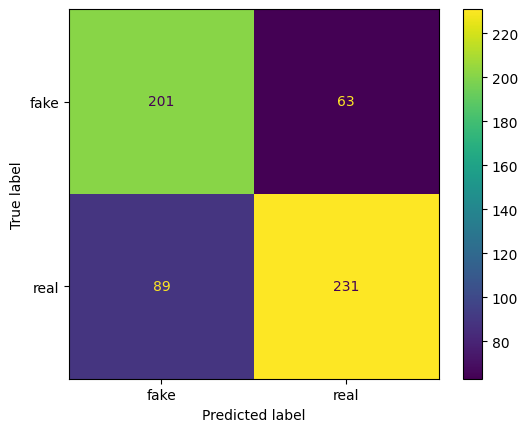

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

#ConfusionMatrixDisplay(model1, X_train, y_train, cmap=plt.cm.Blues)

predictions = model2.predict(X_train)
cm = confusion_matrix(y_train, predictions, labels=model2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model2.classes_)
disp.plot()
plt.show()

We can see that this classifier does a better job classifying `fake` articles accurately. However, it makes more mistakes than the simple one-word model when classifying `real` articles -- 89 of `real` articles were classified as `fake.

Let's take a look at the model's coefficients:

In [ ]:
log_reg = model2.named_steps['logisticregressioncv']
coefs = (pd.DataFrame({'word': word_features, 'coef': log_reg.coef_[0]})
         .set_index('word')
         .sort_values('coef')
        )
#dfs_side_by_side(coefs.iloc[:8], coefs.iloc[8:])
print(coefs.iloc[:8])
print(coefs.iloc[8:])

              coef
word              
trump    -0.955494
donald   -0.391950
investig -0.249009
fbi      -0.131233
joke     -0.129245
cnn      -0.073442
antifa   -0.041278
homeless  0.063087
              coef
word              
shutdown  0.086382
state     0.134280
hillary   0.175282
clinton   0.223437
princ     0.295201
military  0.440347
vote      0.696752
congress  0.770896


We can interpret the weights by looking at their signs. For example, the negative weights on `trump` and `donald` indicate that the model predicts that new articles that have these words have a lower probability of being real. The reverse is true for words like `congress` and `vote`, which have positive weights.

Although this model performs better than the simple one-word model, we still had to hand-pick the word features using our knowledge of the news. What if we forgot to include words that are highly predictive? To address this, we can incorporate all the words in the articles using the tf-idf transform.

## Predicting with the tf-idf Transform

TF-IDF (term frequency-inverse document frequency) is a statistical measure that evaluates the importance of a word in a document or corpus. It takes into account both the frequency of the word in the document (TF) and the rarity of the word in the corpus (IDF). The TF part of the measure indicates how often a particular word occurs in a document, whereas the IDF part measures the relative rarity of that word in the entire corpus. Essentially, TF-IDF is a numerical representation of the importance of words in a document.

Let's use the tf-idf transform to vectorize the entire text of all articles in the training set. This means that our classifier will be able to use all the words in the training set's news articles for prediction. As we've done when we introduced tf-idf, we'll first remove stopwords, tokenize the words, then use the `TfidfVectorizer` from `scikit-learn`.

In [ ]:
import nltk
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(nltk.corpus.stopwords.words('english'))
porter_stemmer = PorterStemmer()

def stemming_tokenizer(document):
    return [porter_stemmer.stem(word)
            for word in nltk.word_tokenize(document)
            if word not in stop_words]
    return words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
tfidf = TfidfVectorizer(tokenizer=stemming_tokenizer)

In [ ]:
from sklearn.compose import make_column_transformer

model3 = make_pipeline(
    FunctionTransformer(lowercase),
    make_column_transformer((tfidf, 'content')),
    LogisticRegressionCV(Cs=10,
                         solver='saga',
                         n_jobs=8,
                         max_iter=1000),
    verbose=True,
)

In [ ]:
%%time

model3.fit(X_train, y_train)
print(f'{model3.score(X_train, y_train):.1%} accuracy on training set.')

[Pipeline]  (step 1 of 3) Processing functiontransformer, total=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



[Pipeline] . (step 2 of 3) Processing columntransformer, total=  15.4s
[Pipeline]  (step 3 of 3) Processing logisticregressioncv, total=  25.3s
100.0% accuracy on training set.
CPU times: user 1min 14s, sys: 180 ms, total: 1min 14s
Wall time: 57 s


We find that this model achieves 100% accuracy on the training set. We can take a look at the tf-idf transformer to better understand the model. Let's start by finding out how many unique tokens the classifier uses:

In [ ]:
tfidf = model3.named_steps.columntransformer.named_transformers_.tfidfvectorizer
n_unique_tokens = len(tfidf.vocabulary_.keys())
print(f'{n_unique_tokens} tokens appeared across {len(X_train)} examples.')

23800 tokens appeared across 584 examples.


This means that our classifier has 23,804 features, a large increase from our previous model which only had 16. Since we can't display that many model weights, we'll display the ten most negative and ten most positive weights below:

In [ ]:
log_reg = model3.named_steps.logisticregressioncv
coefs = (pd.DataFrame(tfidf.vocabulary_.keys(),
                      columns=['word'],
                      index=tfidf.vocabulary_.values())
         .sort_index()
         .assign(coef=log_reg.coef_[0])
         .sort_values('coef')
        )
#dfs_side_by_side(coefs.iloc[:10], coefs.iloc[-10:])

print(coefs.iloc[:10])
print(coefs.iloc[-10:])

               word       coef
21437         trump -10.898854
23772             ” -10.758735
23771             “  -9.705350
0                 !  -9.096918
23769             ‘  -8.924059
22088        vaccin  -8.364700
7366        comment  -8.257952
21357  trendolizer™  -8.237309
12527      investig  -7.944630
13597          like  -7.817675
             word       coef
18352      romney   7.443652
6555       candid   7.636798
140            --   7.676507
16168        page   7.903408
14224      mccain   8.268198
20957    thompson   8.622300
138             ,   9.387031
18047  republican   9.427166
18638       sater  10.851623
22229       video  12.171698


Displaying these features shows a few quirks about this model. For example, we see that several influential features correspond to punctuation in the original text. It's unclear whether we should clean out the punctuation in the model. On one hand, punctuation doesn't seem to convey as much information as words do. On the other, it seems plausible that lots of explanation points in an article could help a model decide whether the article is real or fake. In this case, we've decided to keep punctuation, but curious readers can repeat this analysis after stripping the punctuation out to see how the resulting model is affected.

Let's conclude by displaying the test set error for all three models:

In [ ]:
pd.DataFrame({
    'test set error': [model1.score(X_test, y_test),
                       model2.score(X_test, y_test),
                       model3.score(X_test, y_test)]
}, index=['model1', 'model2', 'model3'])

,test set error
model1,0.641026
model2,0.687179
model3,0.882051


As we might expect, the models became more accurate as we introduced more features. The final model that used tf-idf performed significantly better than the models with binary hand-picked word features. This illustrates a common tradeoff in modeling: given enough data, more complex models can often outperform simpler ones, especially in situations like our case study where simpler models have too much model bias to perform well. However, complex models can be more difficult to interpret. For example, our tf-idf model had over 23,804 features which makes it harder to concisely explain to another person how our model makes its decisions.

In addition, we need to be careful about what our models are useful for. In this case, our models use the content of the news articles for prediction, making them highly dependent on the words that appear in the training set. However, our models will likely not perform as well on future news articles that use words that didn't appear in the training set. For example, our models use the US election candidates' names in 2016 for prediction, but won't know to incorporate the names of the candidates in 2020 or 2024. To use our models in the longer term, we would need to address this issue of *drift*. 

That said, it's surprising that a logistic regression model can perform well with a relatively small amount of feature engineering (tf-idf). We've addressed our original research question: our tf-idf model appears effective for detecting fake news in our dataset, and could plausibly generalize to other news published in the same time period covered in the training data.

# Using multiple ML models

We will utilize LazyClassifier, a Python library, to compare the performance of various models on the FakeNews dataset. LazyClassifier enables quick testing and comparison of the efficiency of multiple machine learning models on a particular dataset. It is designed to provide a quick overview of the performance of different models without the need for extensive coding or parameter tuning. Lets install lazypredict to use LazyClassifier.

In [ ]:
!pip install lazypredict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import nltk
import pandas as pd
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split

Here, we are using the code from previous cells for tf-idf Transform

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(nltk.corpus.stopwords.words('english'))
porter_stemmer = PorterStemmer()

def stemming_tokenizer(document):
    return [porter_stemmer.stem(word)
            for word in nltk.word_tokenize(document)
            if word not in stop_words]
    return words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
url="https://web.lums.edu.pk/~ihsan/workshop_data/unit5/fake_news.csv"
# Load the FakeNewsNet dataset
df = pd.read_csv(url, usecols=['content', 'label'])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df['content'], df['label'],
    test_size=0.25, random_state=42,
)

# Transform the text into numerical features using TF-IDF
tfidf = TfidfVectorizer(tokenizer=stemming_tokenizer)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Convert sparse matrix to dense as some models don't work on sparse matrix
X_train_df = X_train_tfidf.toarray()
X_test_df = X_test_tfidf.toarray()

***The cell below takes ~6 minutes to run, as it fits 29 models on the given dataset.***

In [ ]:
lazy_classifier = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = lazy_classifier.fit(X_train_df, X_test_df, y_train, y_test)

100%|██████████| 29/29 [04:29<00:00,  9.31s/it]


In [ ]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
AdaBoostClassifier,0.86,0.85,None,0.86,10.87
LGBMClassifier,0.85,0.85,None,0.85,2.64
RandomForestClassifier,0.85,0.85,None,0.85,2.13
ExtraTreesClassifier,0.85,0.84,None,0.85,2.70
LinearSVC,0.84,0.83,None,0.84,35.38
PassiveAggressiveClassifier,0.84,0.83,None,0.83,1.49
BaggingClassifier,0.81,0.80,None,0.80,4.19
RidgeClassifierCV,0.79,0.78,None,0.78,1.58
RidgeClassifier,0.79,0.78,None,0.78,1.44


The difference in accuracy of LogisticRegression in lazyclassifier and model3 is because of its hyperparameters. In model3 we use LogisticRegressionCV that  automatically select the best hyperparameters for a logistic regression model through cross-validation. LazyClassifier does not perform hyperparameter tuning like LogisticRegressionCV, it uses default parameters of scikit-learn models.

In [ ]:
# from lazypredict.Supervised import LazyClassifier
# from sklearn.datasets import load_breast_cancer
# from sklearn.model_selection import train_test_split

# data = load_breast_cancer()
# X = data.data
# y= data.target

# X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.5,random_state =123)

# clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
# models,predictions = clf.fit(X_train, X_test, y_train, y_test)

# print(models)